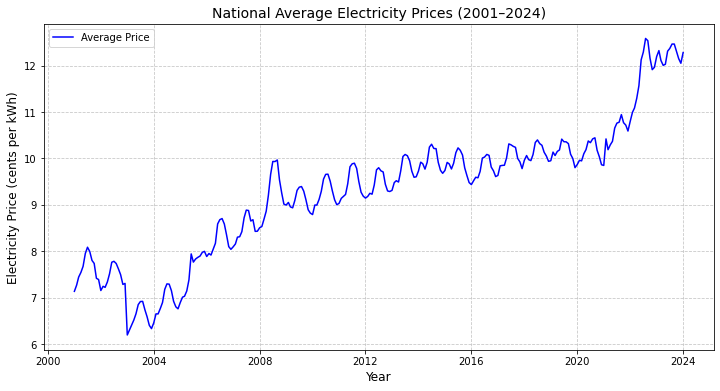

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


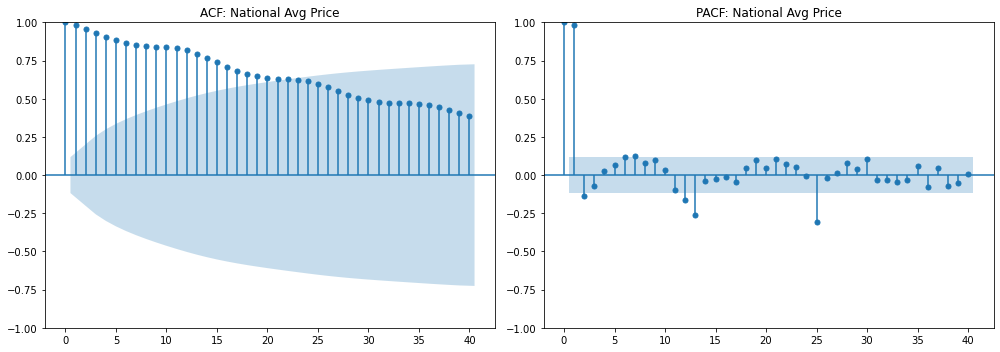

ADF Test Results:
ADF Statistic: -0.7041099663117623
p-value: 0.8456820897741512
Critical Values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
#file_url = 'https://raw.githubusercontent.com/hnngocvo/STATS-207-Final-Project/refs/heads/main/clean_data.csv?token=GHSAT0AAAAAAC3HY4YZS7SYJRAKKR27QQYCZ2PS76Q'
electricity_data = pd.read_csv('clean_data.csv')

# Aggregate the data: compute the monthly average electricity price at the national level
electricity_data['date'] = pd.to_datetime(
    electricity_data[['year', 'month']].assign(day=1)
)  # Create a date column for time series analysis

# Calculate the monthly average price
national_avg_price = electricity_data.groupby('date')['price'].mean().reset_index()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(national_avg_price['date'], national_avg_price['price'], label='Average Price', color='blue')
plt.title('National Average Electricity Prices (2001–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Electricity Price (cents per kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Perform the Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(national_avg_price['price'])

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(national_avg_price['price'], lags=40, ax=axes[0], title="ACF: National Avg Price")
plot_pacf(national_avg_price['price'], lags=40, ax=axes[1], title="PACF: National Avg Price")
plt.tight_layout()
plt.show()

# Display ADF test results
adf_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4],
}
print("ADF Test Results:")
for key, value in adf_results.items():
    print(f"{key}: {value}")


### Take first differencing

In [ ]:
# Apply first differencing to the national average price
national_avg_price['price_diff'] = national_avg_price['price'].diff()

# Drop the first row (NaN due to differencing)
differenced_series = national_avg_price.dropna(subset=['price_diff'])


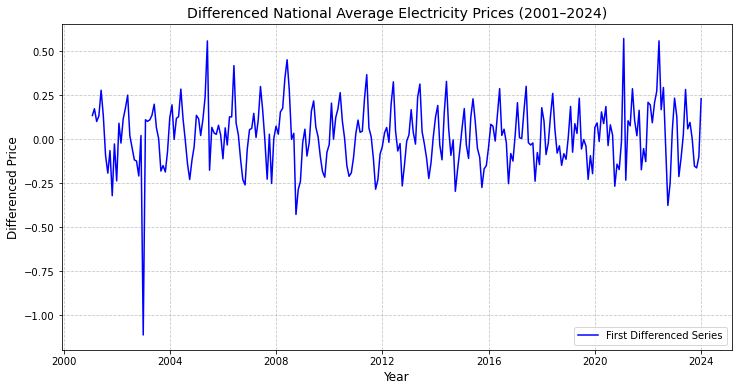

ADF Test Results after First Differencing:
ADF Statistic: -3.130199671439681
p-value: 0.024397511624005407
Critical Values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}


In [ ]:
# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(differenced_series['date'], differenced_series['price_diff'], label='First Differenced Series', color='blue')
plt.title('Differenced National Average Electricity Prices (2001–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Differenced Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Recheck stationarity using the Augmented Dickey-Fuller test
adf_test_diff = adfuller(differenced_series['price_diff'])

# Display ADF test results
adf_results_diff = {
    "ADF Statistic": adf_test_diff[0],
    "p-value": adf_test_diff[1],
    "Critical Values": adf_test_diff[4],
}
print("ADF Test Results after First Differencing:")
for key, value in adf_results_diff.items():
    print(f"{key}: {value}")


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


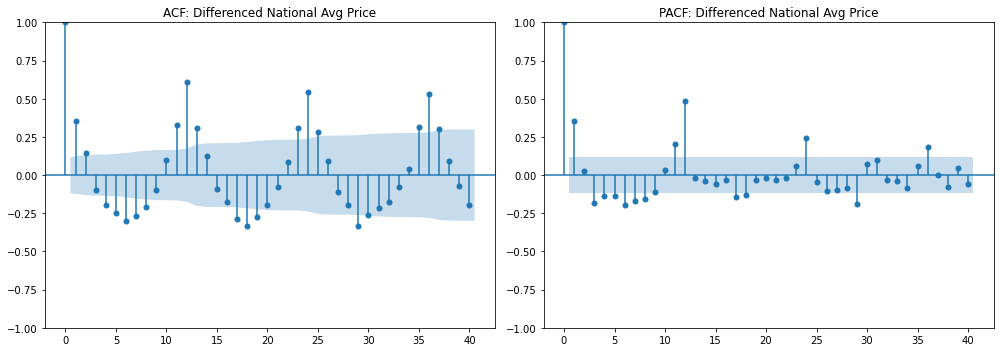

In [5]:
# Plot ACF and PACF of the differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(differenced_series['price_diff'], lags=40, ax=axes[0], title="ACF: Differenced National Avg Price")

# PACF plot
plot_pacf(differenced_series['price_diff'], lags=40, ax=axes[1], title="PACF: Differenced National Avg Price")

plt.tight_layout()
plt.show()


## De-trend and Normalize the Data
After aggregating the national average electricity price, we de-trend the series by fitting a linear regression model.
Normalize the residuals (detrended series) for further stationarity analysis.

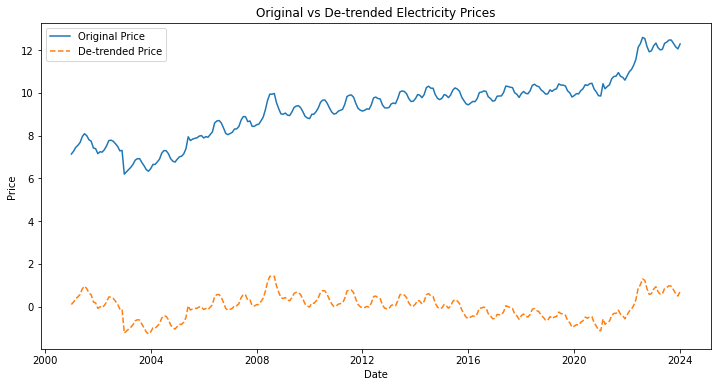

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for de-trending
x = np.arange(len(national_avg_price)).reshape(-1, 1)  # Time index as predictor
y = national_avg_price['price'].values.reshape(-1, 1)

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)
trend = model.predict(x)

# Calculate residuals (detrended series)
detrended = y - trend

# Normalize residuals
detrended_normalized = (detrended - np.mean(detrended)) / np.std(detrended)

# Add detrended and normalized values to the DataFrame
national_avg_price['detrended'] = detrended.flatten()
national_avg_price['detrended_normalized'] = detrended_normalized.flatten()

# Plot the original series and the detrended series
plt.figure(figsize=(12, 6))
plt.plot(national_avg_price['date'], national_avg_price['price'], label="Original Price")
plt.plot(national_avg_price['date'], national_avg_price['detrended'], label="De-trended Price", linestyle='--')
plt.legend()
plt.title("Original vs De-trended Electricity Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


## Stationarity Test: Augmented Dickey-Fuller (ADF)
Run the ADF test to verify stationarity of the detrended and normalized series.

In [7]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(national_avg_price['detrended_normalized'])
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] <= 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is not stationary (fail to reject null hypothesis).")


ADF Test Statistic: -3.2770545462637335
p-value: 0.015935814764450103
Critical Values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
The series is stationary (reject null hypothesis).


## Plot ACF and PACF
To analyze the autocorrelation structure and identify potential AR and MA terms for the ARIMA model.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


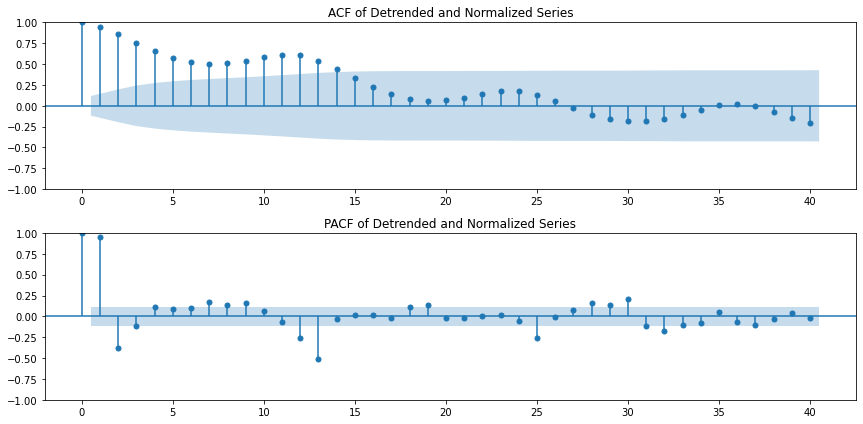

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the detrended and normalized series
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(211)
plot_acf(national_avg_price['detrended_normalized'], lags=40, ax=plt.gca())
plt.title("ACF of Detrended and Normalized Series")

# PACF Plot
plt.subplot(212)
plot_pacf(national_avg_price['detrended_normalized'], lags=40, ax=plt.gca())
plt.title("PACF of Detrended and Normalized Series")

plt.tight_layout()
plt.show()


## Grid Search for Best SARIMA Model
Fit SARIMA models on the detrended_normalized series and find the best parameters based on AIC.

In [9]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Define parameter grids for SARIMA
p = range(0, 3)  # AR terms
d = range(0, 2)  # Differencing
q = range(0, 3)  # MA terms
P = range(0, 3)  # Seasonal AR terms
D = range(0, 2)  # Seasonal Differencing
Q = range(0, 3)  # Seasonal MA terms
s = [12]  # Seasonality (monthly data)

# Create a grid of all parameter combinations
parameters = list(itertools.product(p, d, q, P, D, Q, s))

# Perform grid search
best_aic = float("inf")
best_params = None
best_model = None

for param in parameters:
    try:
        # Fit SARIMA model
        model = SARIMAX(
            national_avg_price['detrended_normalized'],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], param[6]),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False)

        # Check AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
    except Exception as e:
        continue

# Output best parameters and AIC
print(f"Best SARIMA parameters: {best_params}")
print(f"Best AIC: {best_aic}")


Best SARIMA parameters: (0, 1, 2, 2, 1, 1, 12)
Best AIC: -150.991080923399


## Time-Series Cross-Validation
forecast cross-validation to evaluate the forecasting capability of the model

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)
errors = []

# Perform rolling forecast with a validation set
for train_index, test_index in tscv.split(national_avg_price):
    # Define train, validation, and test sets
    train_val = national_avg_price.iloc[train_index]['detrended_normalized']
    test = national_avg_price.iloc[test_index]['detrended_normalized']

    # Split the train_val into training and validation (80% train, 20% validation)
    split_idx = int(0.8 * len(train_val))
    train = train_val[:split_idx]
    validation = train_val[split_idx:]

    # Fit model on training data
    model = SARIMAX(
        train,
        order=(best_params[0], best_params[1], best_params[2]),
        seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    results = model.fit(disp=False)

    # Forecast for validation set
    validation_forecast = results.forecast(steps=len(validation))
    validation_rmse = sqrt(mean_squared_error(validation, validation_forecast))
    print(f"Validation RMSE for fold: {validation_rmse}")

    # Refit the model on training + validation data
    combined_train = train_val  # Combine train and validation
    model = SARIMAX(
        combined_train,
        order=(best_params[0], best_params[1], best_params[2]),
        seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    results = model.fit(disp=False)

    # Forecast for the test set
    test_forecast = results.forecast(steps=len(test))
    test_rmse = sqrt(mean_squared_error(test, test_forecast))
    errors.append(test_rmse)
    print(f"Test RMSE for fold: {test_rmse}")

# Average RMSE across folds
avg_rmse = np.mean(errors)
print(f"Average Test RMSE from cross-validation: {avg_rmse}")


Validation RMSE for fold: 1.0324997889330807
Test RMSE for fold: 2.2181039663022726
Validation RMSE for fold: 0.6707552503231022
Test RMSE for fold: 2.9456996430072584
Validation RMSE for fold: 0.6586583857488792
Test RMSE for fold: 0.6827460942758637
Validation RMSE for fold: 0.6002389386044051
Test RMSE for fold: 0.29733525554467505
Validation RMSE for fold: 0.17814654695383444
Test RMSE for fold: 2.481920890929483
Average Test RMSE from cross-validation: 1.7251611700119103


## Residual Diagnostics (Ljung-Box Test)
After fitting the best SARIMA model, examine residuals for white noise behavior using the Ljung-Box test.

In [ ]:
best_model


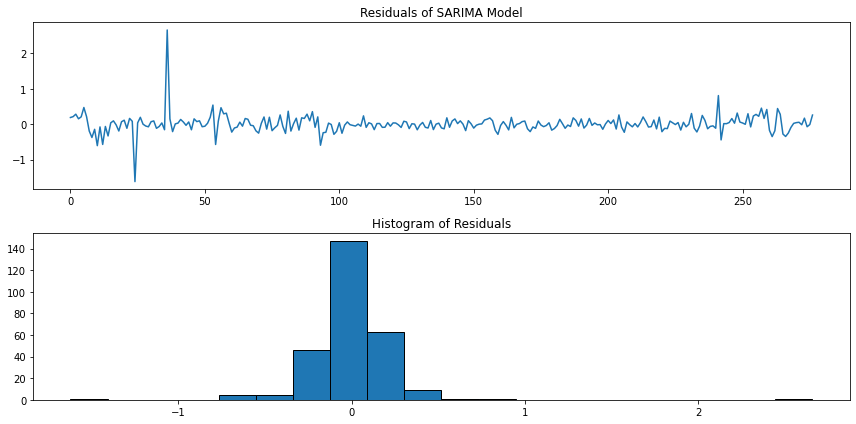

      lb_stat  lb_pvalue
20  25.484779    0.18351
Residuals appear to be white noise (fail to reject null hypothesis).


In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuals of the best model
residuals = best_model.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title("Residuals of SARIMA Model")

plt.subplot(212)
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

# Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=[20], return_df=True)
print(lb_test)

if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print("Residuals appear to be white noise (fail to reject null hypothesis).")
else:
    print("Residuals are not white noise (reject null hypothesis).")
